# Tutorial 1: MuCoST for DLPFC datasets of 10X Visium

We use slice \#151673 in human dorsolateral perfrontal cortex as an example, which comprises 7 distinct domains that correspond to the human dorsolateral perfrontal cortex layers and white matter(WM). These domains have been annotated by morphological features and marker genes, thus providing a valuable resource for assessing the clustering accuracy of the learned representations. By clustering the latent representations of MuCoST, we can observe the consistency with the ground truth. Through visualization, the quality of representation learning is further analyzed, such as the density of spots within the clusters, the consistency of spatial layer distribution, and the spatial trajectory.

## import MuCoST

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from MuCoST.mucost import training_model
from MuCoST.utils import mclust
from MuCoST.config import set_arg

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## hyperparameter setting

In [2]:
opt = set_arg()
arg = opt.parse_args(['--mode_his', 'noh'])
arg.n_domain=7
arg

Namespace(seed=2023, latent_dim=50, epoch=1000, lr=0.001, weight_decay=0.0, log_step=10, drop_feat_p=0.2, flow='source_to_target', radius=150, rknn=6, knn=6, n_domain=7, temp=0.05, n_refine=25, mode_his='noh', mode_rknn='rknn')

## reading data

In [3]:
section_id = '151673'
input_dir = os.path.join('Data/1-DLPFC', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
# histology mode
# img=cv2.imread(input_dir + "/spatial/full_image.tif")
# adata.uns['image']=img
adata

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## showing ground truth

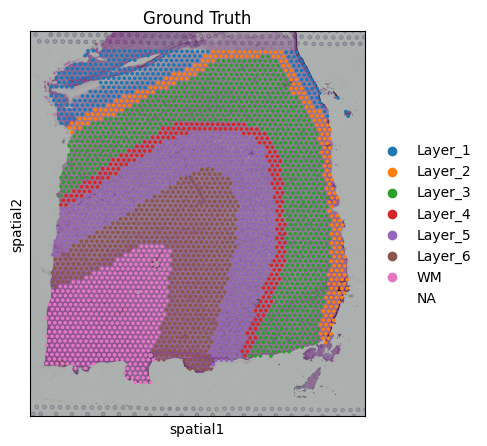

In [4]:
Ann_df = pd.read_csv(os.path.join('Data/1-DLPFC_annotations', section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

## training model

Average spatial edge: 5.8048914536960705
Average feature edge: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

EP[ 100]: loss=0.8170.
EP[ 200]: loss=0.8038.
EP[ 300]: loss=0.7964.
EP[ 400]: loss=0.7923.
EP[ 500]: loss=0.7897.
EP[ 600]: loss=0.7874.
EP[ 700]: loss=0.7871.
EP[ 800]: loss=0.7851.
EP[ 900]: loss=0.7844.
EP[1000]: loss=0.7856.


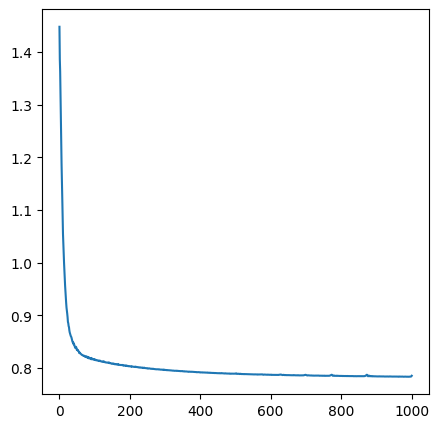

In [5]:
training_model(adata, arg)

## clustering with muclust

In [6]:
adata = mclust(adata, arg, refine=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## computing ARI

In [7]:
adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.6310


## UMAP visualization

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


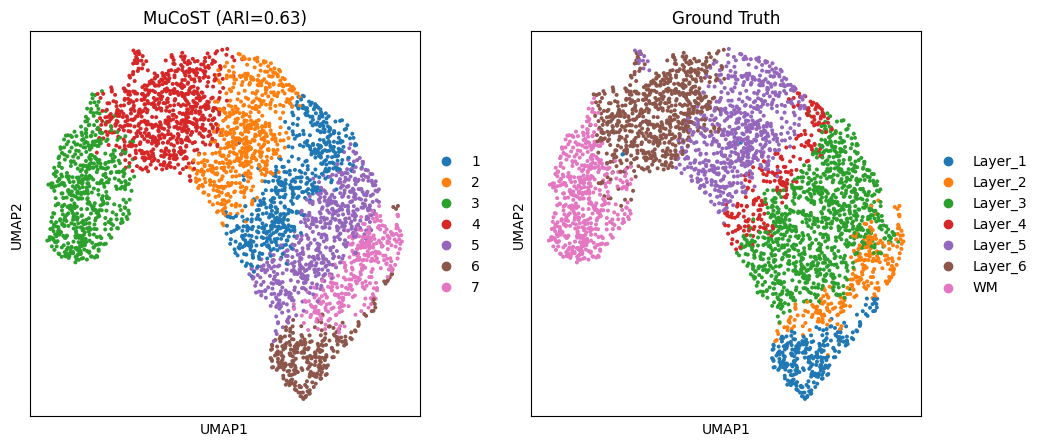

In [8]:
sc.pp.neighbors(adata, use_rep='MuCoST')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['MuCoST (ARI=%.2f)'%ARI, "Ground Truth"])

## heatmap of density

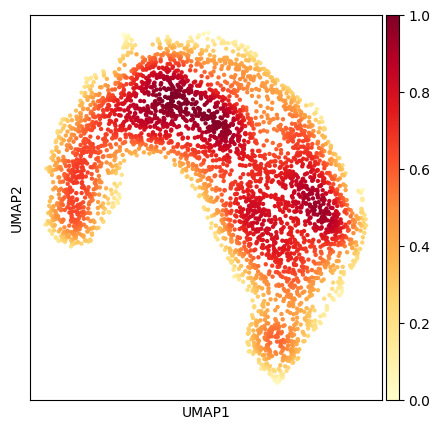

In [9]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.tl.embedding_density(adata, basis='umap')
sc.pl.embedding_density(adata, basis='umap',fg_dotsize=40)

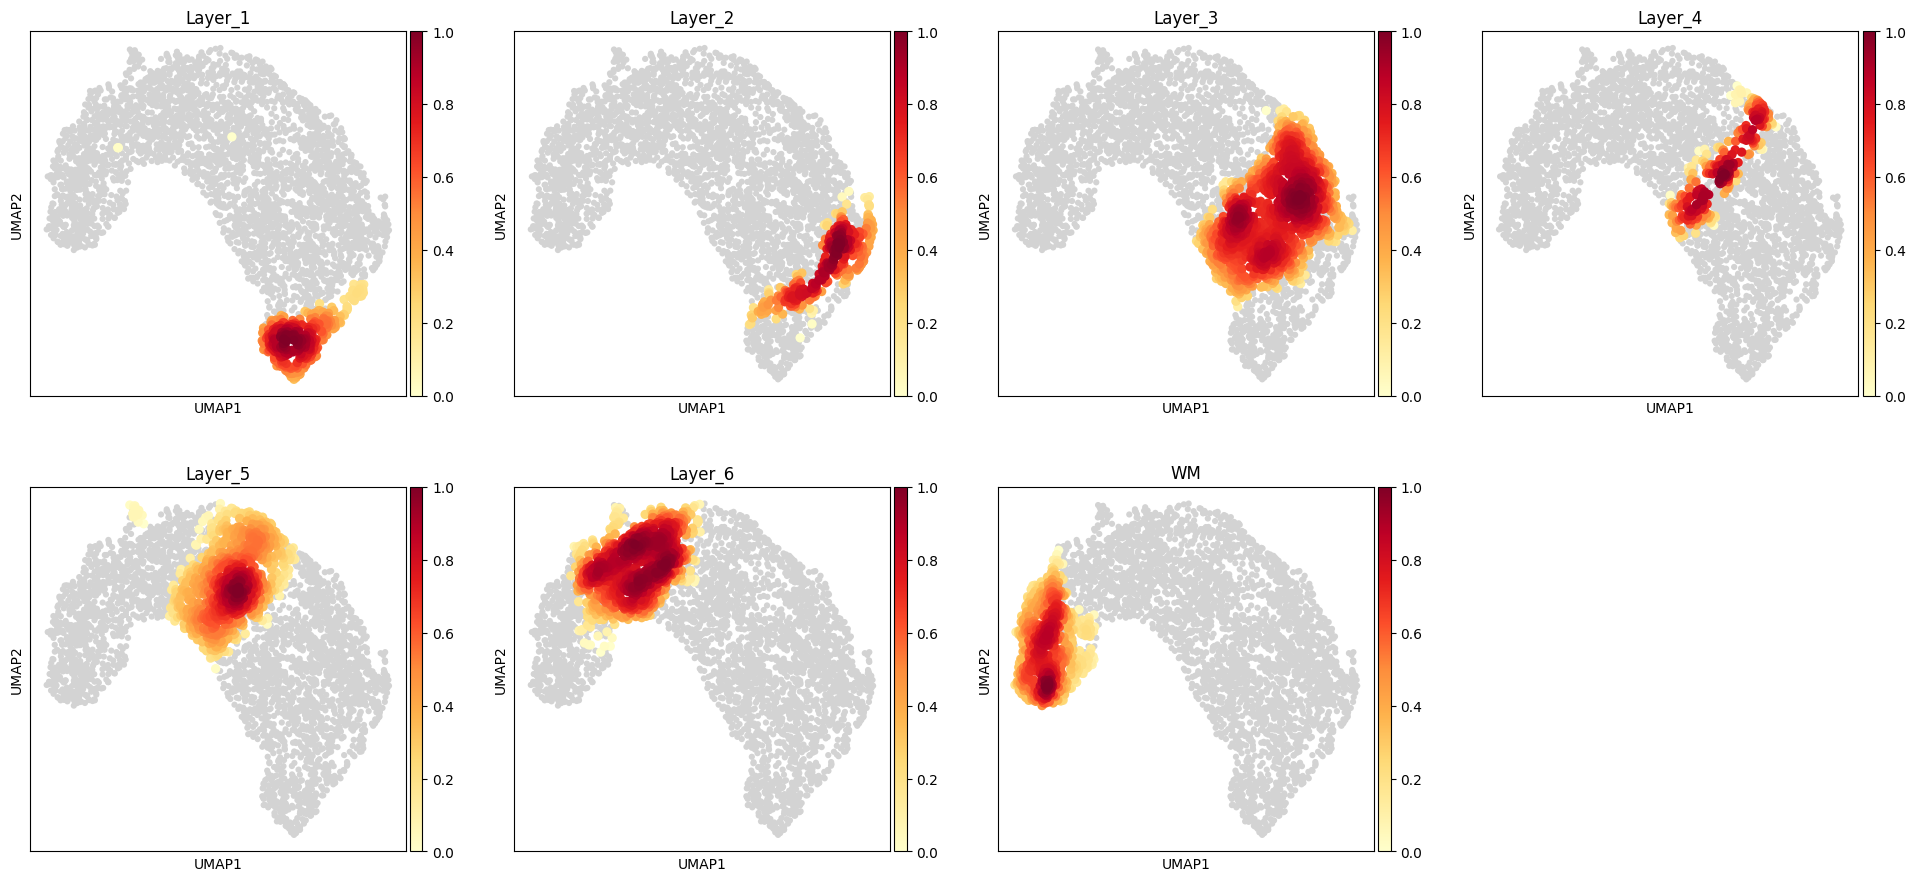

In [10]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.tl.embedding_density(adata, basis='umap', groupby='Ground Truth')
sc.pl.embedding_density(adata, basis='umap', groupby='Ground Truth')

## spatial architectures

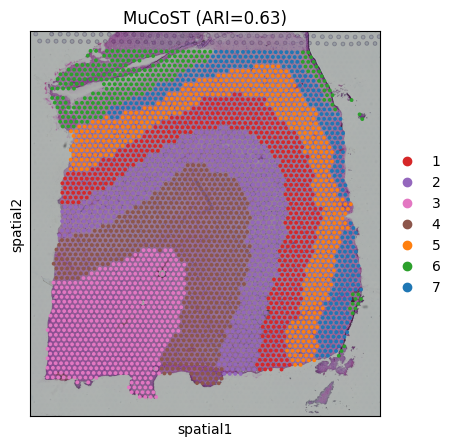

In [11]:
plot_color=[ "#d62728", "#9467bd","#e377c2", "#8c564b", "#ff7f0e", "#2ca02c","#1f77b4" ]
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, color=["mclust"],palette=plot_color, title=['MuCoST (ARI=%.2f)'%ARI])

## paga trajectory inference

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/tools/_paga.py:122: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

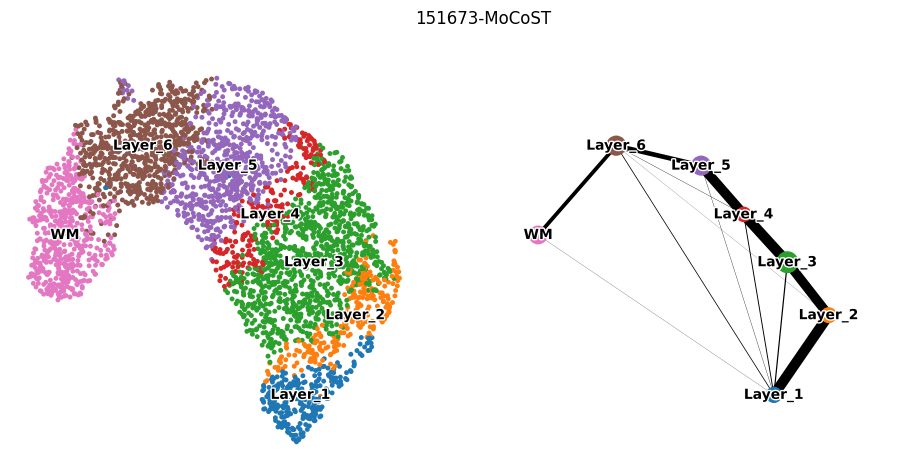

In [12]:
adata = adata[adata.obs['Ground Truth'].notna(),:]
sc.tl.paga(adata,groups='Ground Truth')
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=50,
                   title=section_id+'-MoCoST', legend_fontoutline=2, show=False)